### This is with training with 4 training and 2 validation

From the various trained model, we check the the results on the validation of Bern


In [1]:
import torch
import torch.nn.functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.special import softmax
import sys
import model_zoo
import data_freiburg_numpy_to_hdf5
from utils import make_dir_safely, normalize_image
from losses import compute_dice

In [2]:
# Bern data
# This has already done Bern_numpy_to_hdf5.py
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
bern_tr = h5py.File(basepath + '/bern_images_and_labels_from_101_to_104.hdf5','r')
bern_vl = h5py.File(basepath + '/bern_images_and_labels_from_105_to_106.hdf5','r')
images_tr = bern_tr['images_train'][:]
labels_tr = bern_tr['labels_train'][:]
images_vl = bern_vl['images_validation'][:]
labels_vl = bern_vl['labels_validation'][:]        

## Using model

In [3]:
# load saved model
loss = "dice"
out_channels = 2
in_channels = 4
run = 1
note = '_full_run_bern_full'
cut_z = True
da = 0.0
model_path = f'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_{da}nchannels{in_channels}_r{run}_loss_{loss}_cut_z_{cut_z}{note}'
#model_path = f'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_{da}nchannels{in_channels}_r_phase_dice_cut_z_5_debug'
#model_path = "/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels1_r_DEBUG_LOSS_phase_dice_cut_z_0"
best_model_path = os.path.join(model_path, list(filter(lambda x: 'best' in x, os.listdir(model_path)))[-1])
print(best_model_path)
model = model_zoo.UNet(in_channels, out_channels);
model.load_state_dict(torch.load(best_model_path, map_location=torch.device('cpu')));
model.eval();

/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full/model_best_100_step_9000.pth


In [4]:
if cut_z != False:
    keep_indices_tr = np.where(bern_tr['alias'][:] ==0)[0]
    keep_indices_vl = np.where(bern_vl['alias'][:] ==0)[0]
    images_tr = images_tr[keep_indices_tr]
    labels_tr = labels_tr[keep_indices_tr]
    images_vl = images_vl[keep_indices_vl]
    labels_vl = labels_vl[keep_indices_vl]

### Compute loss

In [5]:
def iterate_minibatches_validation(images, labels, batch_size):
    """
    Function to create mini batches from the dataset of a certain batch size
    :param images: input images
    :param labels: labels
    :param batch_size: batch size
    :return: mini batches"""
    assert len(images) == len(labels)
    
    # Generate randomly selected slices in each minibatch

    n_images = images.shape[0]
    random_indices = np.arange(n_images)
    np.random.shuffle(random_indices)

    # Use only fraction of the batches in each epoch

    for b_i in range(0, n_images, batch_size):

        if b_i + batch_size > n_images:
            continue


        # HDF5 requires indices to be in increasing order
        batch_indices = np.sort(random_indices[b_i:b_i+batch_size])

        X = images[batch_indices, ...]
        y = labels[batch_indices, ...]
        
        # ===========================
        # check if the velocity fields are to be used for the segmentation...
        # ===========================
        if in_channels == 1:
            X = X[..., 1:2]
        
        yield X, y


In [6]:
def dice_score_bern(images_set, labels_set, batch_size = 4):
        dice_score = 0
        for n_batch, batch in enumerate(iterate_minibatches_validation(images_set, labels_set, batch_size = batch_size)):
                model.eval()
                with torch.no_grad():
                        inputs, labels = batch
                
                        # From numpy.ndarray to tensors
                
                        # Input (batch_size, x,y,t,channel_number)
                        inputs = torch.from_numpy(inputs)
                        # Input (batch_size, channell,x,y,t)
                        inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
                        # Labels (batch,size, x,y,t)
                
                        #inputs = inputs.to(device)
                        labels = torch.from_numpy(labels)#.to(device)
                        labels = torch.nn.functional.one_hot(labels.long(), num_classes = out_channels)
                        labels = labels.transpose(1,4).transpose(2,4).transpose(3,4)
                        
                        
                        logits = model(inputs.float())
                        
                        _, mean_dice,_= compute_dice(logits, labels)
                        
                        dice_score += mean_dice  
        return dice_score, n_batch
        

In [7]:
print("Training dice on BERN only")
dice_score_tr, n_batch_tr = dice_score_bern(images_tr, labels_tr, batch_size = 4)
print("Total average dice score: ", dice_score_tr/(n_batch_tr+1))

Training dice on BERN only
Total average dice score:  tensor(0.8133)


In [8]:
print("Validation dice on BERN only")
dice_score_vl, n_batch_vl = dice_score_bern(images_vl, labels_vl, batch_size = 4)
print("Total average dice score: ", dice_score_vl/(n_batch_vl+1))

Validation dice on BERN only
Total average dice score:  tensor(0.6778)


### The following few blocks are results on teh validation set for a few predermined slices for visualization,

for the whole Bern validation dataset + dice score: skip
[Here](##validation_Bern)

In [ ]:
"""
Random:
batch_size = 8
np.random.seed(0)
inputs = images_vl[np.sort(np.random.randint(len(images_vl), size = batch_size))]
np.random.seed(0)
labels = labels_vl[np.sort(np.random.randint(len(images_vl), size = batch_size))]



patient_n = 0
# By patient
batch_size = 9
indexes_z_slices =np.arange(0, (32 - 2*cut_z), (32 - cut_z)//8)
indexes =np.arange((32 -2 *cut_z)*patient_n, (32 - 2*cut_z)*(patient_n + 1), (32 - cut_z)//8)
inputs = images_vl[indexes]
labels = labels_vl[indexes]
"""

In [46]:
patient_n = 0
batch_size = 9
if cut_z != False:
    print("It is cut")
    # When cut
    patients_indexes = [0, 50,104, 150, 200,242, 328]
    train_indexes = [0, 50,104,150, 200]
    val_indexes = [0, 42,92]

    # For patient 0
    
    indexes_zslices = np.arange(val_indexes[0],val_indexes[1] , 1)
    indexes = np.linspace(val_indexes[0], val_indexes[1], batch_size, dtype = int)
    inputs = images_vl[indexes]
    labels = labels_vl[indexes]

    


elif cut_z == True:
    # When not cut
    patients_indexes_not_cut = [0, 56,116, 168, 224,272, 328]
    train_indexes_not_cut = [0, 56,116, 168, 224]
    val_indexes_bot_cut = [0, 48,105]

    
    indexes_zslices = np.arange(val_indexes_bot_cut[0],val_indexes_bot_cut[1] , 1)
    indexes = np.linspace(val_indexes_bot_cut[0], val_indexes_bot_cut[1], batch_size, dtype = int)
    inputs = images_vl[indexes]
    labels = labels_vl[indexes]

It is cut


In [47]:


print(inputs.shape, labels.shape)
inputs = torch.from_numpy(inputs)
# Input (batch_size, channell,x,y,z)
inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
labels = torch.from_numpy(labels)
print(inputs.shape, labels.shape)
n_range = 9
preds = np.array([]).reshape(0, 2,144, 112,48)
for i in range(n_range):
    model.eval()
    with torch.no_grad():
        pred = model(inputs[i*batch_size//n_range:(i+1)*batch_size//n_range])
        preds = np.vstack([preds, pred.detach().numpy()])
        prediction = softmax(preds, axis=1).argmax(axis = 1)

(9, 144, 112, 48, 4) (9, 144, 112, 48)
torch.Size([9, 4, 144, 112, 48]) torch.Size([9, 144, 112, 48])


In [48]:
prediction.shape, labels.shape

((9, 144, 112, 48), torch.Size([9, 144, 112, 48]))

In [49]:
%matplotlib inline
def plot_time(t = 0):
    fig, axs = plt.subplots(4,4);
    img = 0
    for i, ax in enumerate(axs.reshape(-1)):
        
        if i%2 == 0:
            ax.imshow(prediction[img,:,:,t])
            

        else:
            ax.imshow(labels[img,:,:,t].detach().numpy())   
            img = img + 1 
        
    plt.show()

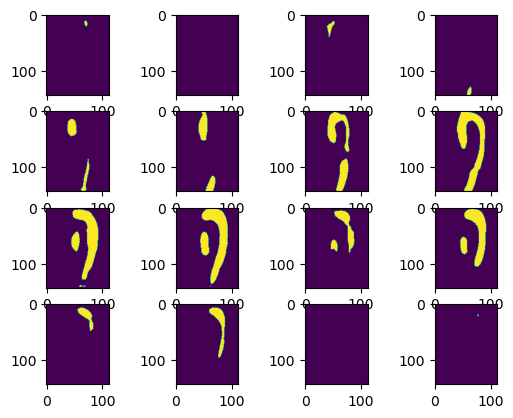

In [50]:
plot_time(0)

In [51]:
def plot_batches(array, input_image = False):

    if input_image:
        fig, axs = plt.subplots(2, 4, figsize=(10,10))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,1,:,:,7])
        plt.show()
    else:
        fig, axs = plt.subplots(2, 4, figsize=(10,10))
        for n, ax in enumerate(axs.reshape(-1)):
            ax.imshow(array[n,:,:,7])
        plt.show()

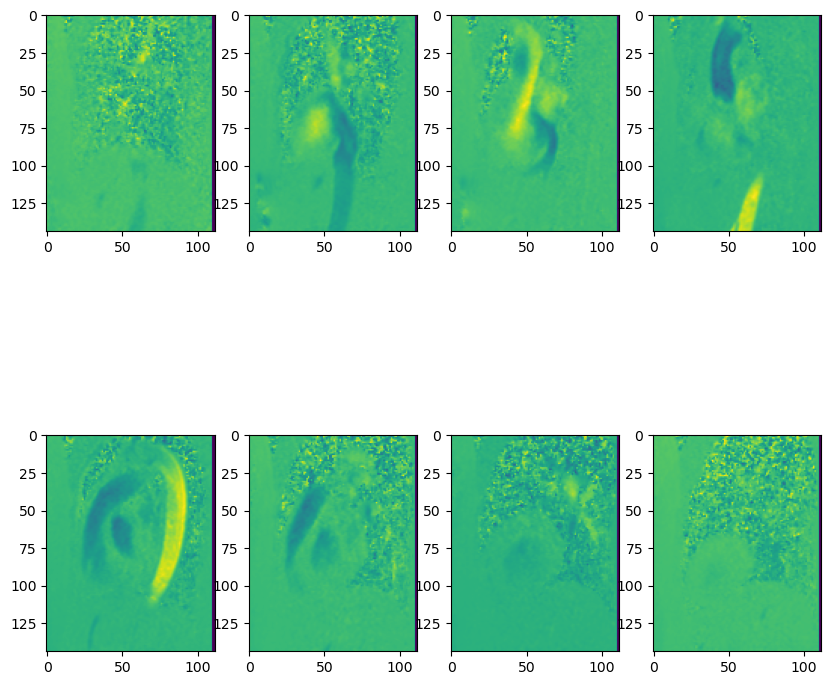

In [52]:
plot_batches(inputs, input_image=True)

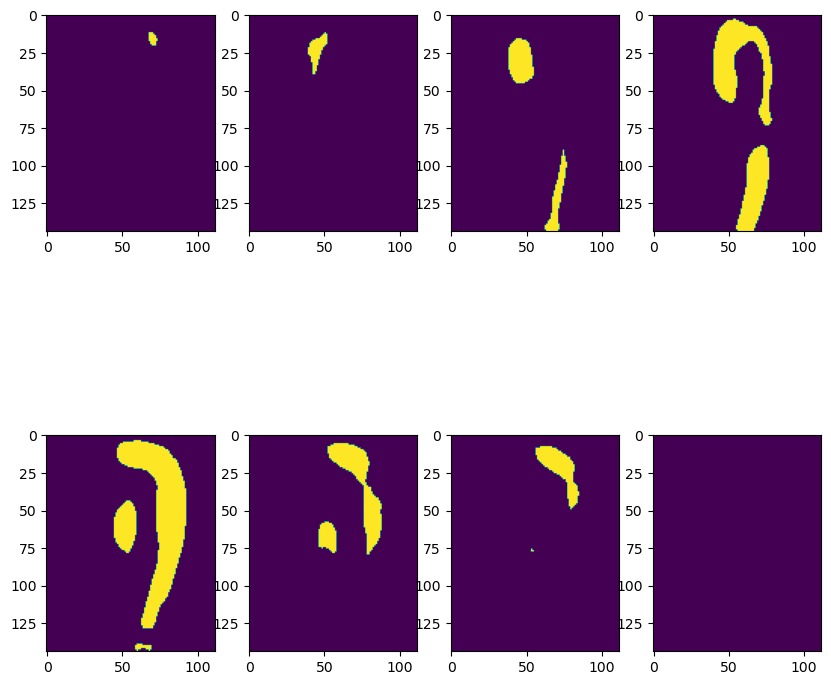

In [53]:
plot_batches(prediction)

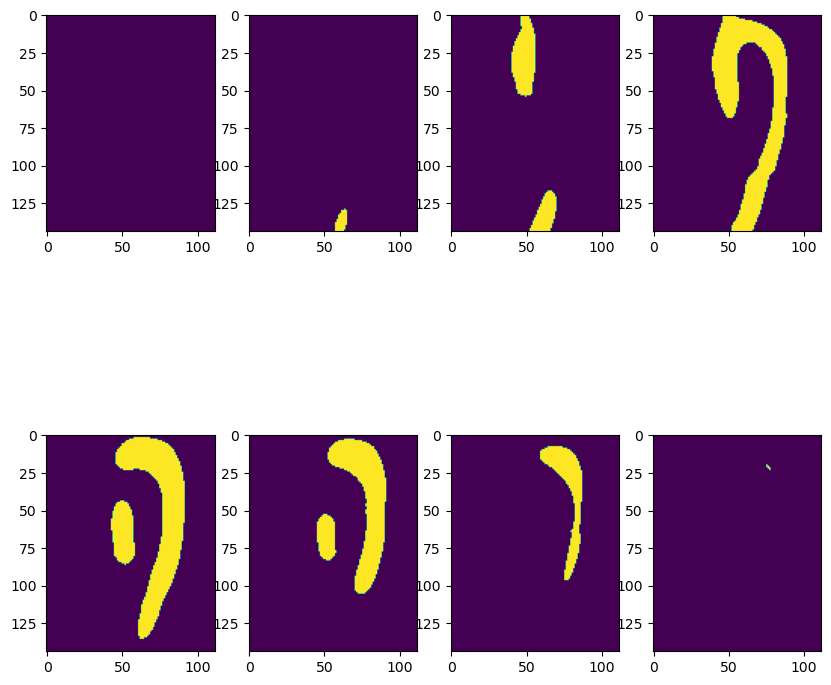

In [54]:
plot_batches(labels)

In [55]:
%matplotlib inline
def presentation_viz_by_patient(input, gt, pred, time, save_path, note_save, indexes, n_channels = 4):
    z_slices = np.arange(0, len(indexes))
    
    # Create directory if it does not exist
    if save_path is not None:
        make_dir_safely(save_path)
    if n_channels == 4:
        h = 18
    else:
        h = 7
    
    fig, axs = plt.subplots(2+n_channels, len(z_slices), figsize = (18,h))
    nbatch = 0
    n_chan = n_channels
    ax = axs.reshape(-1)
    axes_index = 0
    for chan in range(n_channels):
        
        for i, z_slice in enumerate(indexes):
            
            ax[axes_index].imshow(input[i, n_channels - n_chan, :, :, time])
            ax[axes_index].set_title(f"z_{z_slice}_ch:{n_channels - n_chan}_t_{time}", fontsize = 10)
            axes_index += 1
        n_chan -= 1
    for i, z_slice in enumerate(indexes):
        ax[axes_index].imshow(pred[i, :,:, time])
        ax[axes_index].set_title(f"z_{z_slice}_pred_t_{time}", fontsize = 10)
        axes_index +=1
    for i, z_slice in enumerate(indexes):
        ax[axes_index].imshow(gt[i, :,:, time])
        ax[axes_index].set_title(f"z_{z_slice}_gt_t_{time}", fontsize = 10)
        axes_index +=1
    plt.savefig(save_path + f"{note_save}_t_{time}.png", bbox_inches='tight')
    plt.show()
    
        

In [56]:
save_path = os.path.join(model_path + "/results/visualization/Bern/")

In [57]:
save_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full/results/visualization/Bern/'

torch.Size([9, 144, 112, 48])

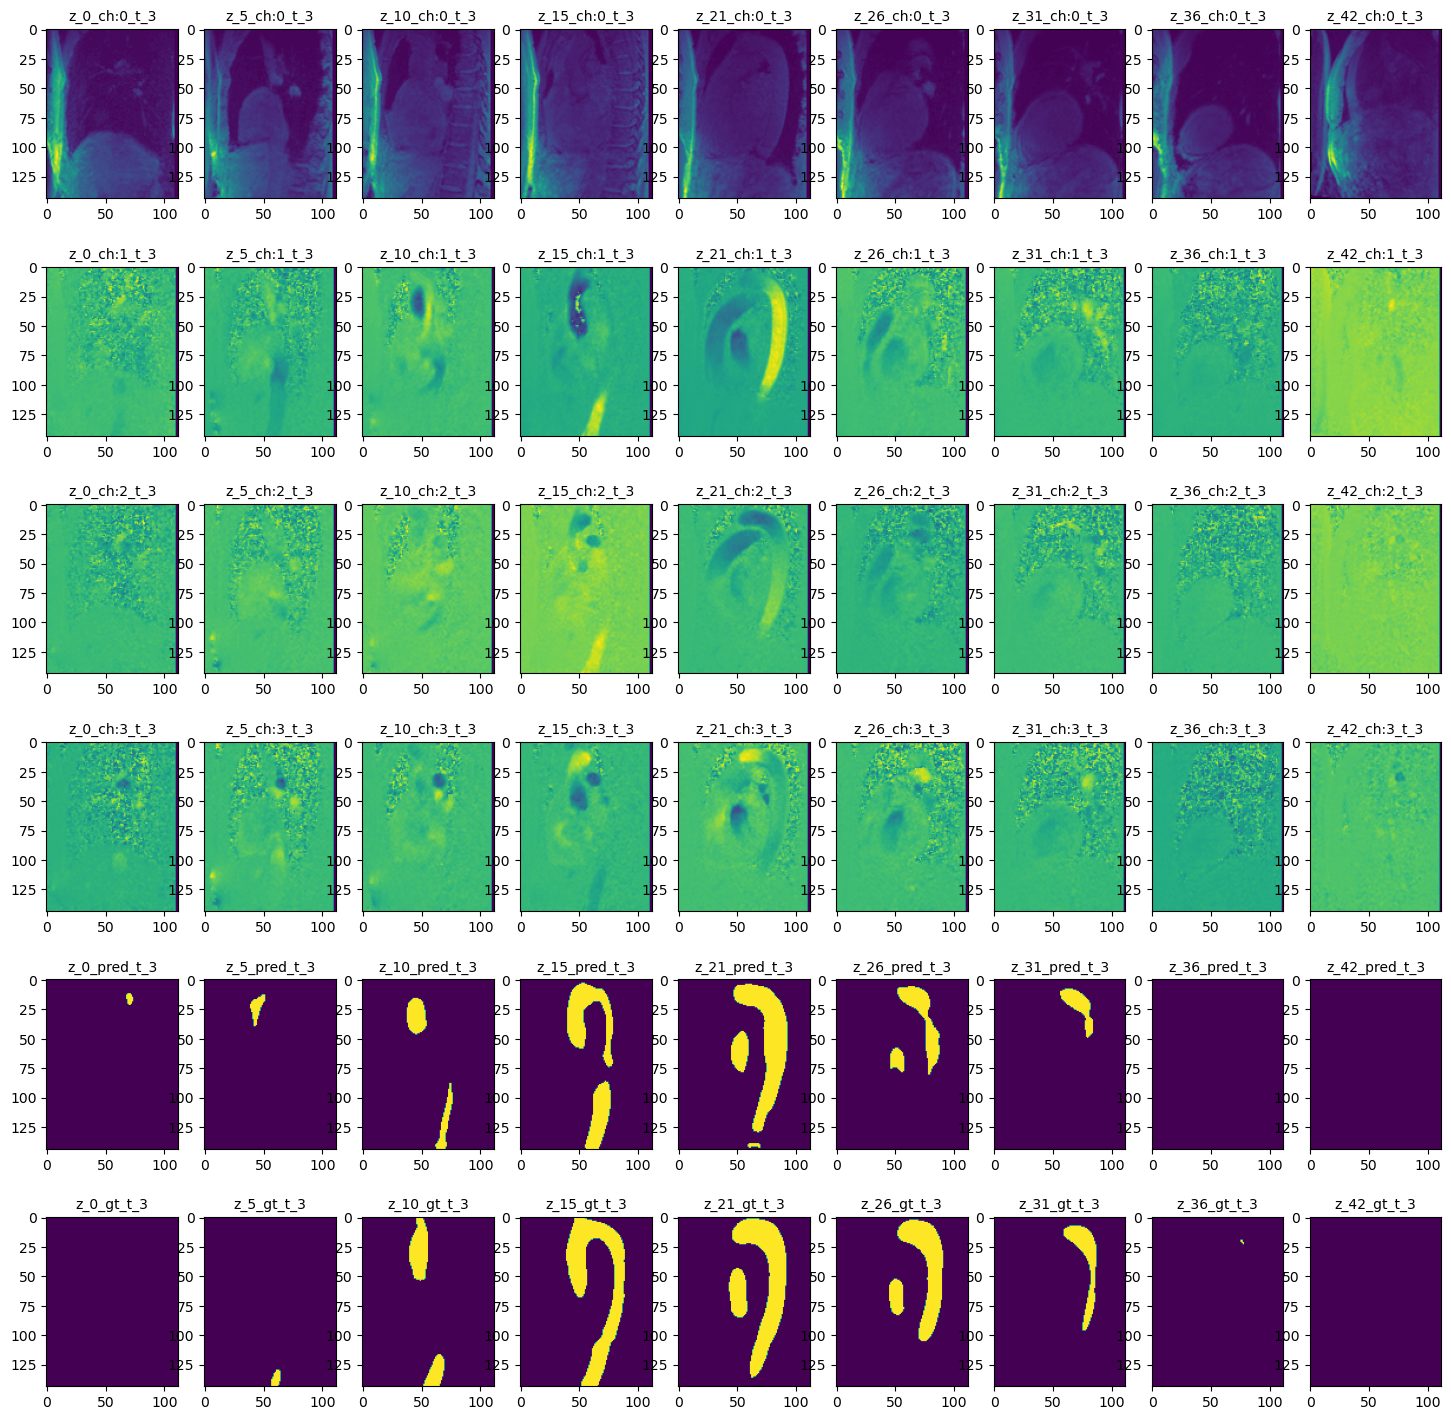

In [61]:
presentation_viz_by_patient(inputs, labels, prediction, time = 3, save_path = save_path, indexes = indexes,note_save = "patient_0")

### Save the total prediction for a patient for future visualization in 3D

In [5]:

patient_n = 0
batch_size = 9
if cut_z != False:
    print("It is cut")
    # When cut
    patients_indexes = [0, 50,104, 150, 200,242, 328]
    train_indexes = [0, 50,104,150, 200]
    val_indexes = [0, 42,92]

    
    indexes = np.arange(val_indexes[0], val_indexes[1],1)
    

    


elif cut_z == True:
    # When not cut
    patients_indexes_not_cut = [0, 56,116, 168, 224,272, 328]
    train_indexes_not_cut = [0, 56,116, 168, 224]
    val_indexes_bot_cut = [0, 48,105]

    
    indexes_zslices = np.arange(val_indexes_bot_cut[0],val_indexes_bot_cut[1] , 1)
    
inputs = images_vl[indexes]
labels = labels_vl[indexes]
print(inputs.shape, labels.shape)


It is cut
(42, 144, 112, 48, 4) (42, 144, 112, 48)


In [6]:
inputs = torch.from_numpy(inputs)
# Input (batch_size, channell,x,y,z)
inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
labels = torch.from_numpy(labels)
print(inputs.shape, labels.shape)
preds = np.array([]).reshape(0, 2,144, 112,48)
for i in range(inputs.shape[0]):
    model.eval()
    with torch.no_grad():
        pred = model(inputs[None, i, :, :,:,:])
        preds = np.vstack([preds, pred.detach().numpy()])
        prediction = softmax(preds, axis=1).argmax(axis = 1)

prediction_axes = np.transpose(prediction, (1, 2, 0, 3))






torch.Size([42, 4, 144, 112, 48]) torch.Size([42, 144, 112, 48])


In [12]:
model_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full'

In [11]:
save_path_pred = model_path + "/results/visualization/Bern_patient_level_prediction/"
make_dir_safely(model_path + "/results/visualization/Bern_patient_level_prediction/")
file_name = 'freiburg_model_prediction_105.npy'
save_path = os.path.join(save_path_pred, file_name)
np.save(save_path, prediction_axes)


In [7]:
model_path

'/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_True_full_run_bern_full'

In [8]:
from utils import make_dir_safely

### Now compute the dice score for each patient - memory issues might arise ...
so instead compute statistics on batches


## Validation_Bern

In [ ]:
SEED = 0 
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:
images_vl.shape, labels_vl.shape

In [ ]:

indexes_patient = np.arange(0, len(images_vl)//2)
inputs_patient = images_vl[indexes_patient]
labels_patient = labels_vl[indexes_patient]
print(inputs_patient.shape, labels_patient.shape)
inputs_patient = torch.from_numpy(inputs_patient)
# Input (batch_size, channell,x,y,z)
inputs_patient.transpose_(1,4).transpose_(2,4).transpose_(3,4)
labels_patient = torch.from_numpy(labels_patient)
print(inputs_patient.shape, labels_patient.shape)

In [ ]:
def iterate_minibatches_validation(images, labels, batch_size):
    """
    Function to create mini batches from the dataset of a certain batch size
    :param images: input images
    :param labels: labels
    :param batch_size: batch size
    :return: mini batches"""
    assert len(images) == len(labels)
    
    # Generate randomly selected slices in each minibatch

    n_images = images.shape[0]
    random_indices = np.arange(n_images)
    np.random.shuffle(random_indices)

    # Use only fraction of the batches in each epoch

    for b_i in range(0, n_images, batch_size):

        if b_i + batch_size > n_images:
            continue


        # HDF5 requires indices to be in increasing order
        batch_indices = np.sort(random_indices[b_i:b_i+batch_size])

        X = images[batch_indices, ...]
        y = labels[batch_indices, ...]
        
        # ===========================
        # check if the velocity fields are to be used for the segmentation...
        # ===========================
        if in_channels == 1:
            X = X[..., 1:2]
        
        yield X, y


In [ ]:
dice_score = 0
for n_batch, batch in enumerate(iterate_minibatches_validation(images_vl, labels_vl, batch_size = 4)):
        model.eval()
        with torch.no_grad():
                print(n_batch)
                inputs, labels = batch
        
                # From numpy.ndarray to tensors
        
                # Input (batch_size, x,y,t,channel_number)
                inputs = torch.from_numpy(inputs)
                # Input (batch_size, channell,x,y,t)
                inputs.transpose_(1,4).transpose_(2,4).transpose_(3,4)
                # Labels (batch,size, x,y,t)
        
                #inputs = inputs.to(device)
                labels = torch.from_numpy(labels)#.to(device)
                labels = torch.nn.functional.one_hot(labels.long(), num_classes = out_channels)
                labels = labels.transpose(1,4).transpose(2,4).transpose(3,4)
                
                
                logits = model(inputs.float())
                
                _, mean_dice,_= compute_dice(logits, labels)
                
                dice_score += mean_dice  
print("Total average dice score: ", dice_score/(n_batch+1))